In [ ]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer

# Tic Toc Toe environment

Our 1st game is the famous Tic Toc Toe. You can read about the game and its rules here: https://en.wikipedia.org/wiki/Tic-tac-toe

We implemented the game as an environment in the style of games in the [Python GYM library](https://gym.openai.com/). The commented source code is available in the file "tic_env.py". Here, we give a brief introduction to the environment and how it can be used.

### Initialization and attributes

You can initialize the environment / game as following:

In [ ]:
env = TictactoeEnv()

Which then has the following attributes with the corresponding initial values:

In [ ]:
env.__dict__

The game is played by two players: player 'X' and player 'O'. The attribute 'current_player' shows whose turn it is. We assume that player 'X' always plays first.

The attribute 'grid' is a 3x3 numpy array and presents the board in the real game and the state $s_t$ in the reinfocement learning language. Each elements can take a value in {0, 1, -1}:
     0 : place unmarked
     1 : place marked with X 
    -1 : place marked with O 
        
The attribute 'end' shows if the game is over or not, and the attribute 'winner' shows the winner of the game: either "X", "O", or None.  

You can use function 'render' to visualize the current position of the board:

In [ ]:
env.render()

### Taking actions

The game environment will recieve action from two players in turn and update the grid. At each time, one player can take the action $a_t$, where $a_t$ can either be an integer between 0 to 8 or a touple, corresponding to the 9 possible.

Function 'step' is used to recieve the action of the player, update the grid:

In [ ]:
env.step(2)

In [ ]:
env.render()

In [ ]:
env.__dict__

In [ ]:
env.step((1,1))

In [ ]:
env.render()

In [ ]:
env.__dict__

But not all actions are available at each time: One cannot choose a place which has been taken before. There is an error if an unavailable action is taken:

In [ ]:
env.step((0,2))

### Reward

Reward is always 0 until the end of the game. When the game is over, the reward is 1 if you win the game, -1 if you lose, and 0 besides. Function 'observe' can be used after each step to recieve the new state $s_t$, whether the game is over, and the winner, and function 'reward' to get the reward value $r_t$:

In [ ]:
env.observe()

In [ ]:
env.reward(player='X')

In [ ]:
env.reward(player='O')

An example of finishing the game:

In [ ]:
env.step(0)
env.step(3)
env.step(1)

In [ ]:
env.render()

In [ ]:
env.observe()

In [ ]:
env.reward(player='X')

In [ ]:
env.reward(player='O')

# Optimal policy for Tic Toc Toe environment

Fortunately, we know the exact optimal policy for Tic Toc Toe. We have implemented and $\epsilon$-greedy version of optimal polciy which you can use for the project.

In [ ]:
env.reset();

In [ ]:
opt_player = OptimalPlayer(epsilon = 0., player = 'X')

In [ ]:
opt_player.act(env.grid)

In [ ]:
opt_player.player

### An example of optimal player playing against random player

In [ ]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt = OptimalPlayer(epsilon=0., player=Turns[0])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            move = player_rnd.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player = ' +  Turns[0])
            print('Random player = ' +  Turns[1])
            env.render()
            env.reset()
            break


### An example of optimal player playing against optimal player

In [ ]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt_1 = OptimalPlayer(epsilon=0., player=Turns[0])
    player_opt_2 = OptimalPlayer(epsilon=0., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt_1.act(grid)
        else:
            move = player_opt_2.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player 1 = ' +  Turns[0])
            print('Optimal player 2 = ' +  Turns[1])
            env.render()
            env.reset()
            break


## Q-learning 

In [127]:
from collections import defaultdict
from tqdm import tqdm 

coords = lambda pos: (int(pos / 3), pos % 3) 

def eps_greedy(Q, state, grid, epsilon):
    possible_moves = np.where(np.ravel(grid) == 0)[0]
    if np.random.random() < epsilon:
        position = np.random.choice(possible_moves)
    else:
        possible = [int(elem) for elem in np.argsort(Q[state]) if elem in possible_moves]
        position = possible[-1] if possible is not [] else np.random.choice(possible_moves) 
    return (int(position / 3), position % 3) 

#Q learning with greedy
#Dont necessariliy need to train with player_epsilon = 0.5
def q_learning(env, num_episodes, discount_factor=0.99, alpha=0.05, epsilon=0.3, player_epsilon=0.5):
    Q = defaultdict(lambda: np.zeros(9))
    episode_lengths = np.zeros(num_episodes)
    episode_rewards = np.zeros(num_episodes)
    Turns = np.array(['X','O'])

    for i_episode in range(num_episodes):
        env.reset()
        grid, end, winner = env.observe()
        Turns = Turns[np.random.permutation(2)]
        player = OptimalPlayer(epsilon=player_epsilon, player=Turns[1])
        while not end:
            episode_lengths[i_episode] += 1
            if env.current_player == Turns[0]:
                #move = eps_greedy(Q, str(grid), grid, epsilon=epsilon - epsilon/num_episodes*i_episode)
                
                #Remark: for question 2.1 epsilon needs to be constant and not decreasing
                move = eps_greedy(Q, str(grid), grid, epsilon = epsilon)
            else:  
                move = player.act(grid)
            
            new_grid, end, winner = env.step(move, print_grid=False)
            
#             if end: 
#                 Q[str(grid)][move[0] * 3 + move[1]] = env.reward(Turns[0])
#             else: 
#             td_target = (discount_factor * np.max(Q[str(new_grid)])) * alpha 
#             td = (1 - alpha) * Q[str(grid)][move[0] * 3 + move[1]]
#             Q[str(grid)][move[0] * 3 + move[1]] = td + td_target 
            if env.current_player == Turns[1]:
                episode_rewards[i_episode] += env.reward(Turns[0])
                value = Q[str(grid)][move[0] * 3 + move[1]]
                Q[str(grid)][move[0] * 3 + move[1]] += alpha * (env.reward(Turns[0]) + discount_factor * np.max(Q[str(new_grid)]) - value)
            grid = new_grid 
    
    return Q, episode_lengths, episode_rewards

env = TictactoeEnv()
Q, episode_lengths, episode_rewards = q_learning(env, 20000)

We uodate Q values at every move (optimal player and q-learning player)

In [128]:
from matplotlib import pyplot as plt

def q_eval(Q, other_player_epsilon=0.5, games=20000):
    env.reset()
    total_reward = []
    Turns = np.array(['X','O'])
    count_win = 0 
    for i in tqdm(range(games)):
        grid, end, winner = env.observe()
        Turns = Turns[np.random.permutation(2)]
        player = OptimalPlayer(epsilon=other_player_epsilon, player=Turns[1])
        while not end:
            if env.current_player == Turns[0]:
                possible_moves = np.where(np.ravel(grid) == 0)[0]
                possible = [int(elem) for elem in np.argsort(Q[str(grid)]) if elem in possible_moves]
                position = possible[-1] if possible is not [] else np.random.choice(possible_moves)
                move = (int(position / 3), position % 3) 
            else:  
                move = player.act(grid)
            grid, end, winner = env.step(move, print_grid=False)
            
            #total_reward.append(env.reward(Turns[0]))
            if end:
                total_reward.append(env.reward(Turns[0]))
                if(winner == Turns[0]):
                     count_win += 1 
#                 print('-------------------------------------------')
#                 print('Game end, winner is player ' + str(winner))
#                 print('Q-Learning player = ' +  Turns[0])
#                 print('Optimal player = ' +  Turns[1])
#                 env.render()
                
                env.reset()
                break
        
    return np.mean(total_reward), count_win / games 


reward, score = q_eval(Q, other_player_epsilon = 1., games = 2000)
print(score, reward) 

100%|██████████| 2000/2000 [00:01<00:00, 1166.20it/s]

0.7475 0.2294000306889673


In [ ]:
plt.plot(episode_rewards); 

## DQN 

In [ ]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
from itertools import count
import random
from tic_env import TictactoeEnv, OptimalPlayer
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from tqdm import tqdm

In [75]:
#Helper functions

#Modifies state to specification given in project description.
#Takes a grid and returns a 3x3x2 tensor which contains only values 0 or 1
# such that [:, :, 0] are moves taken by me, [: ,:, 1] moves taken by opponent
def modify_state_to_description(grid, my_turn_sign): 
    if('X' == my_turn_sign): #if i am first player to play
        my_array =  np.where(grid == -1, 0, grid) #replace -1's with 0(remove other players moves)
        other_array = np.where(grid == 1, 0, grid)  #replace 1's with 0
        other_array = np.where(other_array == -1, 1, other_array) 
    else: #-1 = my_moves
        my_array = np.where(grid == 1, 0, grid) #remove other players moves
        my_array = np.where(my_array == -1, 1, my_array) #change -1 to 1's 
        other_array = np.where(grid == -1, 0, grid)
    #print("grid")#print(grid)
    state = np.stack((my_array, other_array))
    #print("state")print(state)
    return state

#Given the state, prepares a tensor for the neural network
def get_tensor_for_neural_net(state):
    state = torch.from_numpy(state)
    state = torch.flatten(state)
    return state.unsqueeze(0).type(torch.float32) 

#Given integer representatin of a move, return tuple representation of move
def get_move_from_position(position):
    move = (int(position / 3), int(position) % 3)
    return move

def move_is_legal(move, grid):
    possible_moves = np.where(np.ravel(grid.ravel()) == 0)[0]   
    return move[0]*3 + move[1] in possible_moves

#first player alternates each game
def assign_players(turns, i_episode):
    if(i_episode > 0):
        turns = np.roll(turns, 1) 
    return turns, turns[0], turns[1]


In [76]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Neural net from description
# (fully connected, 2 hidden layers w 128 neurons each and relu, 3x3x2 inputs and 9 outputs)
# (output layer uses linear activation function)
class Policy(nn.Module):

    def __init__(self, n_inputs=3*3*2, n_outputs=9):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_outputs)

    # From description states are 3 ×3 × 2 tensor where
    # where [:, :, 0] are moves taken by me, [: ,:, 1] moves taken by opponent(here they are flattened)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

    def act(self, state):
        with torch.no_grad():
            output = self.forward(state)
            #print(output)
            return output.max(1)[1].view(1, 1)


In [77]:
class DQNActor(): 
    
    def __init__(self, device, batch_size, gamma, memory_size):
        self.device = device
        self.batch_size = batch_size
        self.gamma = gamma
        
        self.memory = ReplayMemory(memory_size)
        
        self.policy = Policy().to(self.device)
        self.target = Policy().to(self.device)
        self.target.load_state_dict(self.policy.state_dict()) #copy state from policy to target
        self.target.eval() #put into eval state(BN, Dropout ect.. are now turned off)

        self.optimizer = optim.Adam(self.policy.parameters(), lr=5e-4) #Description: Adam optimizer with lr = 5e-4

        self.latest_loss = 0
        

    # Taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)),
            device=self.device,
            dtype=torch.bool,
        )
        non_final_next_states = torch.cat(
            [s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        next_state_values[non_final_mask] = self.target(
            non_final_next_states).max(1)[0].detach()
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        #Store lastest loss for plot
        self.latest_loss = loss.detach().numpy().item()

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    #Select action according to epsilon greedy policy.
    def act(self, state: torch.tensor, eps_min, eps_max, n, num_exploratory_games, fixed_epsilon, fixed_eps_threshold): 
        sample = random.random()
        
        #Epsilon update function given in description
        if(fixed_epsilon):
            eps_threshold = fixed_eps_threshold
        else: 
            eps_threshold = max(eps_min, eps_max*(1 - n/num_exploratory_games))       
        # greedy 
        if sample > eps_threshold:
            with torch.no_grad():
                return get_move_from_position(self.policy.act(state)), 0
        else:
            return get_move_from_position(torch.tensor([[random.randrange(9)]],dtype=torch.long)), 1


In [101]:
#Used to evaluate DQN against random and against optimal player

#Given a DQNActor Compute Mopt and Mrand(Defined in project description)
def compute_test_Mrand_Mopt(actor1 : DQNActor):
    n_games = 500
    #print("Mrand: ")
    Mrand = eval_against_optimal_player(actor1, other_player_epsilon = 1., n_games=n_games)
    #print("Mopt: ")
    Mopt = eval_against_optimal_player(actor1, other_player_epsilon = 0., n_games=n_games) 
    
    return Mrand, Mopt#Mrand, Mopt
    
#Evaluate DQNActor over n_games with agains Optimal player with given epsilon and output (wins-losses)/n_games
def eval_against_optimal_player(actor1: DQNActor , other_player_epsilon, n_games = 500):
    Turns = np.array(['X','O'])
    was_invalid = False
    env = TictactoeEnv()
    losses, wins, invalid_moves, ties = 0, 0, 0 ,0
    for i_episode in range(n_games):
        # Initialize the environment and state
        env.reset()
        grid, end, winner = env.observe()
        Turns, player1, player2 = assign_players(Turns, i_episode) #first player changes every game
        
        other_player = OptimalPlayer(other_player_epsilon, player=player2)
        
        #Loop until game ends
        for t in count():
            #print("grid")#print(grid)#print("state")#print(state)
            state = get_tensor_for_neural_net(modify_state_to_description(np.array(grid, dtype=np.float32), env.current_player))
            #print(state)
            # Select and perform an action
            if env.current_player == player1:
                #No random moves for evaluation(eps_min, num_exploratory games ect.. not used here)
                move, _ = actor1.act(state,  eps_min=0, eps_max=0, n=0, num_exploratory_games=0, fixed_epsilon=True, fixed_eps_threshold=0) 
            else:  
                move = other_player.act(grid)

            if move_is_legal(move, grid) == False:
                end, was_invalid = True, True
            else:
                grid, end, winner = env.step(move, print_grid=False)

            # Observe next state
            if not end:
                next_state = modify_state_to_description(np.array(grid, dtype=np.float32), env.current_player)  
                next_state = get_tensor_for_neural_net(next_state)
            #game has ended
            else:
                #count wins losses
                if was_invalid == False:
                    if winner == player1: 
                        wins += 1 
                    elif str(winner) == "None":
                        ties += 1
                    else:
                        losses += 1
                else: 
                    invalid_moves += 1 #Dont care about invalid moves for this evaluation
                was_invalid = False #reset boolean
                next_state = None #because finish game

            # Move to the next state
            state = next_state
            
            if end:
                break
    
    #print("wins: " + str(wins) + ", losses: " + str(losses) + ", ties: " + str(ties) + ", invalid moves: " + str(invalid_moves))
    return (wins - losses)/(n_games)
    

In [99]:
#Training

#Training setup (default settings, this changes slightly depending on question)
NUM_GAMES = 20000 # Description asks to train on 20k games
BATCH_SIZE = 64     # Description sets batch size to 64
GAMMA = 0.99        # Description sets discount factor to 0.99
EPS_MAX = 0.8       # Description suggests this value
EPS_MIN = 0.1       # Description suggests this value
NUM_EXPLORATORY_GAMES = 15000 # Play with this value between [1, 40000], has big impact on how fast we learn
TARGET_UPDATE = 500 # Description: update target_net every 500 games
MEMORY_SIZE = 10000 # Description sets memory size to 10000
OTHER_PLAYER_EPSILON = 0.5
FIXED_EPS_THRESHOLD = 0.3 # Some questions ask for fixed epsilon
FIXED_EPSILON = False     


def train(num_games = NUM_GAMES, batch_size = BATCH_SIZE, gamma = GAMMA, eps_max = EPS_MAX, 
    eps_min = EPS_MIN, num_exploratory_games = NUM_EXPLORATORY_GAMES, target_update = TARGET_UPDATE, 
    memory_size = MEMORY_SIZE, other_player_epsilon = OTHER_PLAYER_EPSILON, 
    fixed_eps_threshold = FIXED_EPS_THRESHOLD, fixed_epsilon = FIXED_EPSILON, evaluate_M_values = False
    ):

    wins, ties, loses, invalid_moves, random_moves, total_moves_player_1 = 0, 0, 0, 0, 0, 0
    was_invalid = False
    Turns = np.array(['X','O'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    actor1 = DQNActor(device = device, batch_size = batch_size, gamma = gamma, memory_size = memory_size);

    env = TictactoeEnv()

    #Keep track of reward and losses for plots
    episode_durations = []
    rewards = []
    losses = [] 
    Mopts = []
    Mrands = []

    # Main Training loop
    # Train over a number of games
    for i_episode in range(num_games):
    
        # Initialize the environment and state
        env.reset()
        grid, end, winner = env.observe()
        Turns, player1, player2 = assign_players(Turns, i_episode) #first player changes every game #ik it works cuz if dont alternaty works rly well
        
        actor2 = OptimalPlayer(epsilon=other_player_epsilon, player=player2)
        
        #Loop until game ends
        for t in count():
            #print("grid")#print(grid)#print("state")#print(state)
            state = get_tensor_for_neural_net(modify_state_to_description(np.array(grid, dtype=np.float32), player1))
            #print(state)
            # Select and perform an action
            if env.current_player == player1:
                move, rand = actor1.act(state, eps_min, eps_max, i_episode, num_exploratory_games, fixed_epsilon, fixed_eps_threshold) 
                random_moves += rand
                total_moves_player_1  += 1
            else:  
                move = actor2.act(grid)

            #From description: if move puts us in an illegal state, we end and give reward = -1.
            #(instead of forcing player to make legal moves)
            if move_is_legal(move, grid) == False:
                #print("not possible move")
                reward = -1
                end, was_invalid = True, True
            else:
                #play move and get reward (Does it make sense to store also other players moves? )
                grid, end, winner = env.step(move, print_grid=False)
                reward = env.reward(player1) 

            # Observe next state
            if not end:
                next_state = modify_state_to_description(np.array(grid, dtype=np.float32), player1)  #probably should be player 1 here
                next_state = get_tensor_for_neural_net(next_state)
            #game has ended
            else:
                #count wins losses ties 
                if was_invalid == False:
                    if winner == player1: 
                        wins += 1 
                    elif str(winner) == "None":
                        ties += 1
                    else:
                        loses += 1
                else: 
                    invalid_moves += 1
                was_invalid = False #reset boolean
                next_state = None #because finish game
        
            #TODO if actor1 is DQNActor or actor2 is DQNActor
            # Store the transition in memory
       
            action = torch.tensor([[move[0] * 3 + move[1]]]) #move
            
            actor1.memory.push(state, action, next_state, torch.tensor([reward]))

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network) of given actors
            actor1.optimize_model()
            
            if end:
                episode_durations.append(t + 1)
                rewards.append(reward)
                losses.append(actor1.latest_loss)
                #print(losses)
                break
        # Update the target network(s), copying all weights and biases in DQN
        if i_episode % target_update == 0:
            actor1.target.load_state_dict(actor1.policy.state_dict())
        
        # Evaluate training
        if (i_episode+1) % 5000 == 0 and i_episode != 1:
            print("For batch of 5000 games: " + " Wins: " + str(wins) + ", Losses: " + str(loses) +
                ", Ties: " + str(ties) + " Invalid moves: " + str(invalid_moves)
                + ", Percentage of random moves: " + str(random_moves/total_moves_player_1))
            wins, ties, loses, invalid_moves, random_moves, total_moves_player_1 = 0, 0, 0, 0, 0, 0 
        
        
        #If want to calculate M values every 250 games
        if(evaluate_M_values == True and (i_episode+1) % 250 == 0 and i_episode != 1):
            Mrand, Mopt = compute_test_Mrand_Mopt(actor1)
            Mrands.append(Mrand)
            Mopts.append(Mopt)
    
    print('Complete')
    return rewards, losses, Mrands, Mopts

In [95]:
#DEMO CELL CAN DELETE AFTER
#Plots
#Demo plot trains with default parameters
rewards, losses, _ , _ = train(other_player_epsilon=1.0, num_exploratory_games= 10000, num_games=20000) #fixed_eps_threshold=0.3, fixed_epsilon=True
#Plot average reward and losses for every 250 games during training
n = 250
avg_rewards = np.average(np.array(rewards).reshape(-1, n), axis=1)
plt.plot(avg_rewards)
#plt.xlabel('250 games') not sure what to name this, 1 unit = 250 games, maybe can scale *250 ? and call it games
plt.ylabel('reward')
plt.savefig('reward.png', bbox_inches='tight')
plt.show()

avg_losses = np.average(np.array(losses).reshape(-1, n), axis=1) 
plt.plot(avg_losses)
#plt.xlabel('250 games')
plt.ylabel('training loss')
plt.savefig('loss.png', bbox_inches='tight')
plt.show()

KeyboardInterrupt: 

In [ ]:
#Question 11
#Plot average reward and average training loss for every 250 games during training. Does
#the loss decrease? Does the agent learn to play Tic Tac Toe?
#Expected answer: A figure with two subplots (caption length < 50 words). Specify your choice of eps.

#TODO Question: should we plot them as subplot or each one their own plot then put them together in overleaf?
thresholds = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4]
#Maybe set title = fixed_eps_threshold
for fixed_eps_threshold in thresholds:
    figure, axes = plt.subplots(nrows=2, ncols=1)

    rewards, losses, _ , _ = train(fixed_epsilon=True, fixed_eps_threshold=fixed_eps_threshold) 
    #Plot average reward and losses for every 250 games during training
    n = 250 # Average over sets of 250 games
    avg_rewards = np.average(np.array(rewards).reshape(-1, n), axis=1)
    x = [i*250 for i in range(len(avg_rewards))]
    axes[0].plot(x, avg_rewards)
    axes[0].set_xlabel('number training games') 
    axes[0].set_ylabel('reward')
    #axes[0].savefig('question11_reward_' + str(fixed_eps_threshold) +'.png', bbox_inches='tight')
    #plt.show()
    avg_losses = np.average(np.array(losses).reshape(-1, n), axis=1) 
    x = [i*250 for i in range(len(avg_losses))]
    axes[1].plot(x, avg_losses)
    axes[1].set_xlabel('number of training games')
    axes[1].set_ylabel('training loss')
    figure.savefig('question11_loss_' + str(fixed_eps_threshold) + '.png', bbox_inches='tight')
    figure.show()


In [104]:
#TODO This question doesnt work
#TODO Question 12, 
#Repeat the training but without the replay buffer and with a batch size of 1: At every
#step, update the network by using only the latest transition. What do you observe?
#Expected answer: A figure with two subplots showing average reward and average training loss during
#training (caption length < 50 words).
#TODO use best fixed_eps computed in Question 11
#TODO setting batch_size = 1 breaks the algorithm =/
rewards, losses, _ , _ = train(memory_size = 1, batch_size = 2, fixed_epsilon=True, fixed_eps_threshold=0.3) 
#Plot average reward and losses for every 250 games during training
n = 250 # Average over sets of 250 games
avg_rewards = np.average(np.array(rewards).reshape(-1, n), axis=1)
x = [i*250 for i in range(len(rewards))]
plt.plot(x, avg_rewards)
plt.xlabel('number training games') 
plt.ylabel('reward')
plt.savefig('question11_reward_' + str(fixed_eps_threshold) +'.png', bbox_inches='tight')
plt.show()
avg_losses = np.average(np.array(losses).reshape(-1, n), axis=1) 
x = [i*250 for i in range(len(avg_losses))]
plt.plot(avg_losses)
plt.xlabel('number of training games')
plt.ylabel('training loss')
plt.savefig('question11_loss_' + str(fixed_eps_threshold) + '.png', bbox_inches='tight')
plt.show()

KeyboardInterrupt: 

For batch of 5000 games:  Wins: 255, Losses: 1723, Ties: 32 Invalid moves: 2990, Percentage of random moves: 0.745048104131296
For batch of 5000 games:  Wins: 359, Losses: 1837, Ties: 58 Invalid moves: 2746, Percentage of random moves: 0.6521530444322545
For batch of 5000 games:  Wins: 490, Losses: 1954, Ties: 96 Invalid moves: 2460, Percentage of random moves: 0.5473946411740945
For batch of 5000 games:  Wins: 520, Losses: 2190, Ties: 109 Invalid moves: 2181, Percentage of random moves: 0.45633375140273286
Complete


/tmp/ipykernel_4921/278103034.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


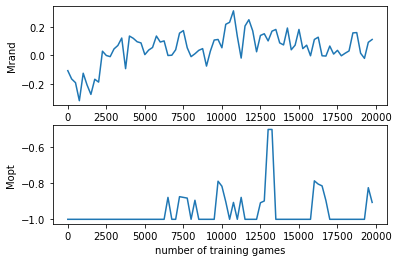

In [105]:
#Instead of fixing eps, use eps(n) in Equation 1. For different values of n∗, run your DQN against Opt(0.5)
#for 20’000 games – switch the 1st player after every game. Choose several values of n∗from a reasonably
#wide interval between 1 to 40’000 – particularly, include n∗= 1.

#TODO create loop to test different n* values (num_exploratory_games)
#Question 13
# After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents.
#Plot Mopt and Mrand over time. Does decreasing eps help training compared to having a fixed eps? What is
#the effect of n∗?
figure, axes = plt.subplots(nrows=2, ncols=1)
#TODO test different num_eploratory_games values
_, _, Mrands , Mopts  = train(num_games = 20000, num_exploratory_games= 20000, evaluate_M_values=True) 
#Plot average reward and losses for every 250 games during training
n = 250 # Average over sets of 250 games
x = [i*250 for i in range(len(Mrands))]
axes[0].plot(x, Mrands)
axes[0].set_xlabel('number training games') 
axes[0].set_ylabel('Mrand')
axes[1].plot(x, Mopts)
axes[1].set_xlabel('number of training games')
axes[1].set_ylabel('Mopt ')
figure.savefig('question13_Mrand_Mopt_2.png', bbox_inches='tight')
figure.show()


In [ ]:
#Choose the best value of n∗ that you found. Run DQN against Opt(eps_opt) for different values of eps_opt for
#20’000 games – switch the 1st player after every game. Choose several values of eps_opt from a reasonably
#wide interval between 0 to 1 – particularly, include eps_opt = 0.

#Question 14. After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents
#for each value of eps_opt. Plot Mopt and Mrand over time. What do you observe? How can you explain it?
#Expected answer: A figure showing Mopt and Mrand over time for different values of eps_opt


In [ ]:
#TODO How to evaluate invalid moves ? think maybe only need this for question 15.
def dqn_eval(other_player_epsilon=0.5, games=20000):
    total_reward = []
    env.reset()
    Turns = np.array(['X','O'])
    count_win, none_win, loose = 0, 0, 0 
    winner_list = [] 
    for i in tqdm(range(games)):
        grid, end, winner = env.observe()
        
        player = OptimalPlayer(epsilon=other_player_epsilon, player=Turns[1])
        while not end:
            if env.current_player == Turns[0]:
                state = modify_state_to_description(np.array([[grid]], dtype=np.int32), Turns[0])
                state = torch.from_numpy(state)
                # Resize, and add a batch dimension (BCHW)
                state = state.unsqueeze(0).type(torch.float32) #mmh suspicious
                position = select_model_action(policy, state)
                move = (int(position / 3), int(position) % 3)
            else:  
                move = player.act(grid)
            #at this point should not be making invalid moves... because player has trained
            grid, end, winner = env.step(move, print_grid=False)
            total_reward.append(env.reward(env.current_player))
            
            if end:
                if winner == Turns[0]: 
                    count_win += 1 
                elif str(winner) == "None":
                    none_win += 1
                else:
                    loose += 1
#                 print('-------------------------------------------')
#                 print('Game end, winner is player ' + str(winner))
#                 print('Q-Learning player = ', Turns[0])
#                 print(f'Another player with epsilon {other_player_epsilon} = ', Turns[1])
        #             env.render()
                env.reset()
                break
    return count_win / games, none_win / games, loose / games, np.mean(total_reward)


In [ ]:
score = dqn_eval(0.5, 1000)
print(f"Wins of DQN: {score[0]}, wins None: {score[1]}, wins Another player: {score[2]}") 